# Tarea 2

Integrantes:
- Sara Sofía Rivera Sanabria.
- Juan Sebastián Rueda Segura.
- Santiago Rocha Pachón.

In [1]:
!pip install matplotlib numpy scipy

## Funciones y clases auxiliares

In [2]:

#TODO: Consider making random_init and diag_init class methods
#TODO: Add blank_init, can be found in H1

In [100]:
import copy

import matplotlib.pyplot as plt
import numpy as np

"""
Implementation of a configuration from some configuration space. It contains
its vertices represented as a list of strings, where each string is a key of
the color dictionary; and a mapping from each vertex to its neighbors, i.e.,
the edges from each vertex to its neighbors
"""
class Config:
    def __init__(self, V: list[str], E: dict, color_dict: dict):
        self.V: list[str] = V #*Vertices
        self.E: dict = E
        self.E_list: list = None
        self.color_dict: dict = color_dict

    def deep_copy(self) -> "Config":
        """
        Create a deep copy of this Config object.
        
        Returns
        -------
        Config
            A new Config object that is a deep copy of this one, ensuring
            no shared references between the original and the copy.
        """
        return Config(
            V=copy.deepcopy(self.V),
            E=copy.deepcopy(self.E),
            color_dict=copy.deepcopy(self.color_dict)
        )

    def get_edges_list(self) -> list[list]:
        """
        Make a list of unique edges (pair of vertices id) based on the
        vertex -> neighbors map E.
        """
        E_set: set = set()
        for current, neighbors in self.E.items():
            for neighbor in neighbors:
                E_set.add(tuple(sorted([current, neighbor])))
        return list(E_set)

    def graph(self) -> None:
        """
        Graph this Config in a square-like arrangement of its vertices.
        It expects the Config to have a number of vertices (in V) that is a
        square number, otherwise, it raises an error.
        """
        #*Check if V has a square number of elements
        if int(len(self.V) ** (1/2)) * int(len(self.V) ** (1/2)) != len(self.V):
            raise ValueError(f"V must have a square number of elements, but it has {len(self.V)}")

        n: int = int(len(self.V) ** (1/2))

        #*Convert array-like M to np array
        V_as_lol: list[list[str]] = []
        for i in range(n):
            V_as_lol.append(self.V[i*n: (i + 1)*n])
        # import pdb; pdb.set_trace()
        V_as_nparr: np.array = np.asarray(V_as_lol)
        rows, cols = V_as_nparr.shape

        #*Instantiate plot
        fig, ax = plt.subplots(figsize=(cols, rows))

        #*Set up coordinate system (fitting grid)
        ax.set_xlim(-0.5, cols - 0.5)
        ax.set_ylim(rows - 0.5, -0.5)
        ax.set_xticks(np.arange(0, cols))
        ax.set_yticks(np.arange(0, rows))

        #*Hide tick marks and labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)

        #*Add edges
        if self.E_list is None:
            self.E_list = self.get_edges_list()
        E_list = self.E_list
        
        for edge in E_list:
            vertex1_id, vertex2_id = edge
            #*Convert vertex ID to (row, col) coordinates
            row1, col1 = vertex1_id // n, vertex1_id % n
            row2, col2 = vertex2_id // n, vertex2_id % n
            #*Plot line between the two vertices (col for x-axis, row for y-axis)
            ax.plot([col1, col2], [row1, row2], linewidth=2, color='black', alpha=0.7)

        #*Calculate size of the circles (particles) depending on the size of M
        cell_width_pts = (fig.get_figwidth() * 72) / max(cols, 1)
        cell_height_pts = (fig.get_figheight() * 72) / max(rows, 1)
        node_size = (0.35 * min(cell_width_pts, cell_height_pts)) ** 2

        #*Plot circles
        for row in range(rows):
            for col in range(cols):
                value = V_as_nparr[row, col]
                if isinstance(value, np.generic):
                    value = value.item()
                facecolor = self.color_dict[value]
                ax.scatter(col, row, s=node_size, c=facecolor, edgecolors='black', zorder=3)

        ax.set_aspect("equal") #*square proportions
        plt.show()

    def get_neighbors(self, vertex_id: int) -> list[int]:
        """
        Return a list of the neighbors'id (i.e., their index in V) of
        V[vertex_id]
        """
        return self.E[vertex_id]

    def is_feasible(self, E: dict = None) -> bool:
        """
        Return True if this configuration is feasible (i.e., no vertex has
        any of the colors of its neighbors) or False if it is not, depending
        on the given neighbor mapping.

        Parameters
        ----------
        - E (dict, optional): The mapping vertex -> neighbors to check the
        feasibility of the configuration on. Defaults to using self's E.
        """
        if E == None:
            E_mapping: dict = self.E
        else:
            E_mapping: dict = E
        for vertex_id, neighbors in E_mapping.items():
            current_vertex_color: str = self.V[vertex_id] #*it is actually the color's key
            for neighbor_id in neighbors:
                neighbor_color: str = self.V[neighbor_id] #*it is actually the color's key
                if current_vertex_color == neighbor_color:
                    return False
        return True

    def is_other_feasible(self, other: "Config") -> bool:
        """
        Return True if `other` is feasible using this Config's
        vertex -> neighbors mapping (E)

        Parameters
        ----------
        other (Config): The Config to check the feasibility of.
        """
        return other.is_feasible(self.E)
    
    def n_possible_q_colorations(self) -> int:
        """
        Return the number of q-colorations (feasible or not) that can be created
        from this `Config`s `E`, `V` and `color_dict`.
        """
        return len(self.color_dict)**len(self.V)
    
    def _build_grid_from_V(self, V: list[str]) -> list[list[str]]:
        """
        Construct a list of (disjoint) lists that store, together, the same number of elements as V. V's lenght must be square.
        """
        #*Check if V has a square number of elements
        if int(len(V) ** (1/2)) * int(len(V) ** (1/2)) != len(V):
            raise ValueError(f"V must have a square number of elements, but it has {len(V)}")
        
        k_root = int(len(V) ** (1/2))
        V_matrix: list[list[str]] = []
        for n in range(k_root):
            V_row: list[str] = []
            for m in range(k_root):
                V_row.append(V[n*k_root + m])
            V_matrix.append(V_row)

        return V_matrix
    
    def _build_V_from_grid(self, V_grid: list[list[str]] | np.ndarray) -> list[str]:
        if isinstance(V_grid, list):
            V: list[str] = []
            for row in V_grid:
                V += row
            return V
        elif isinstance(V_grid, np.ndarray):
            return V_grid.flatten().tolist()
        else:
            raise TypeError(f"V_grid must be a list or numpy array, got {type(V_grid)}")
            

    def random_init(self, V_size: int = 1) -> "Config":
        conf = self.deep_copy()
        colors: list = list(conf.color_dict.keys())
        conf.V = np.random.choice(colors, size=V_size)
        return conf
    
    def diagonal_init(self, V_size = 1) -> "Config":
        conf = self.deep_copy()
        colors = list(conf.color_dict.keys())
        grid_size: int = int(V_size ** (1/2))
        grid = [[0 for _ in range(grid_size)] for _ in range(grid_size)]
        for i in range(grid_size):
            for j in range(grid_size):
                # import pdb; pdb.set_trace()
                grid[i][j] = colors[(i + j) % len(colors)]
        conf.V = conf._build_V_from_grid(grid)
        return conf


    def gibbs_sampler_q_coloration(self, iterations: int) -> "Config":
        """
        Pick a random initial configuration and perform Gibbs' sampling to color the grid.
        The Gibbs sampler picks a random cell and reassigns it a color that does not violate the coloring constraints.
        """
        
        def _valid_colors(x_idx, config: Config) -> list:
            """ 
            Given a position (x, y) (interpret it as a vertex if you wish) in the grid, return the list of colors that can be assigned to that position without violating the coloring constraints.
            """
            try:
                neighbors = config.E[x_idx]
                not_valid_colors: list[str] = [self.V[neighbor] for neighbor in neighbors]
                # print("Not valid colors:", not_valid_colors)
                return [col for col in list(self.color_dict.keys()) if col not in not_valid_colors]
            except BaseException as e:
                # print("Exception:", e)
                return list(self.color_dict.keys())

        result = self
        for _ in range(iterations):
            # (x, y) = np.random.randint(0, grid_size, size=2)
            v_idx = np.random.randint(0, len(result.V))
            valid_colors = _valid_colors(v_idx, result)
            # import pdb; pdb.set_trace()
            # print("Valid colors:", valid_colors)
            # print(v_idx, result.V)
            if valid_colors:
                result.V[v_idx] = np.random.choice(valid_colors)
            # result.graph()

        return result
        


In [101]:
{1, 2, 3, 4} - {1, 2}

{3, 4}

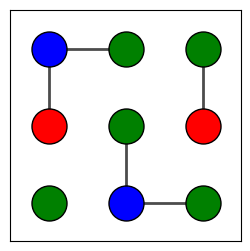

---


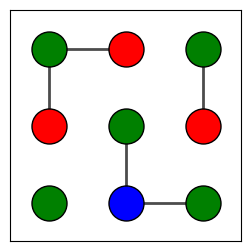

True
Possible 3-colorations in a 3x3 grid: 19683


In [102]:
#*Example use of Config
conf: Config = Config(V=['r', 'g', 'b', 'g', 'b', 'r', 'g', 'r', 'b'],
                      E={0: [1, 3], 2: [3], 7: [5, 8]},
                      color_dict={'r': 'red', 'b': 'blue', 'g': 'green'})
conf2: Config = Config(V=['r', 'g', 'b', 'g', 'b', 'r', 'g', 'r', 'b'],
                      E={0: [1, 3], 2: [1], 7: [4, 8]},
                      color_dict={'r': 'red', 'b': 'blue', 'g': 'green'})
conf3: Config = Config(V=[], E={0: [1, 3], 1: [0], 2: [5], 3: [0], 4: [7], 5: [2] , 7: [4, 8], 8: [7]}, color_dict={'r': 'red', 'b': 'blue', 'g': 'green'})
conf4 = conf3.random_init(V_size=9)
conf5 = conf3.diagonal_init(V_size=9)

# conf5.graph()
# print(conf5.is_feasible())
conf4.graph()
print("---")
conf6 = conf4.gibbs_sampler_q_coloration(20)
conf6.graph()
print(conf6.is_feasible())
# conf4.graph()
# conf2.graph()
# conf.graph()

print("Possible 3-colorations in a 3x3 grid:", conf.n_possible_q_colorations())

## Aproximación del número de q-coloraciones

### Gibbs sampler for q-coloration

In [103]:
from math import log

def estimate_n_q_colorations(k: int = 9, epsilon: float = 0.01, p: float = 1/3, color_dict: dict = {'b': 'negro', 'w': 'blanco'}, verbose: bool = True) -> float:
    """
    This function estimates the number of feasible q-colorations in a graph
    G = (V, E) with probability `p` of the estimate Z_l being in the interval [(1 - `epsilon`)Z_{G, q}, (1 + `epsilon`)Z_{G, q}].
     
    The graph G = (V, E) will be built with |V| = `k` vertices and |E| = 2*√`k` * (√`k` - 1) edges, and forcing each vertex to have degree 2, 3 or 4. A visual representation of the graph the function is expected to work with is shown below:
    ```
    a--b--c
    |  |  |
    d--e--f
    |  |  |
    g--h--j
    ```
    when `k` = 9.

    The algorithm does the following:
    For 0 <= i <= l-1,
        1. Instantiates a `Config` of Z_i called to as `base_config`. Just like its name implies, it is used in the next for loop to instantiate random `Config`s.
        2. Appends the next edge to `current_next_E`, i.e., adds the first vertex to the list of neighbors of the second one and viceversa. `current_next_E` is therefore E_{i+1}
        3. For each m in range(0, (16*|E|)/(`p` * `epsilon`^2)):
            3.1. Creates a `Config` of Z_i (for reference, see Notes) using k * (log(k) + log(8/(`epsilon`l)) - log(d))/ log(q / (2d^2)) steps of Gibbs' random sampler.
            3.2. Checks whether it is feasible using `is_feasible` and `current_next_E`. If it is, adds 1 to `feasible_count`, and either way, increases `total_count` by 1 too.
        4. Appends `feasible_count / total_count` to `estimates`.
    Finally, returns the list of quotient estimates and Z_0 and the product of the elements in the list.

    Parameters
    ----------
    - k : int, optional
        Number of vertices in the graph. Must be a square number. Default is 9.
    - epsilon : float, optional
        Precision of the algorithm. With probability `p`, the product of the 
        estimates will be in the range [(1 - `epsilon`)Z_{G, q}, (1 + `epsilon`)Z_{G, q}]. 
        Default is 0.01.
    - p : float, optional
        Probability that the product of estimates will be in the range 
        [(1 - `epsilon`)Z_{G, q}, (1 + `epsilon`)Z_{G, q}]. Default is 1/3.
    - color_dict : dict, optional
        Mapping key => color, where key will be a possible element of V 
        (a color any vertex may take) and color its respective color to be used 
        when graphing. Default is {'b': 'negro', 'w': 'blanco'}.
    - verbose: bool, optional
        Whether to show the three products of the total number of iterations required
        for the algorithm to work and the estimates as they are calculated.

    Returns
    -------
    (list[float], float)
        A tuple containing a list of the estimates used, and their product as a float.
        
    Notes
    -----

    Builds the graph Z_i, where Z_i = (V, E_i), and E_i = E_{i - 1} U {(x_i, y_i)} with x_i, y_i in V. For each increment in i, an edge is supposed to be added between two vertices. It will start adding the horizontal ones followed by the vertical ones. An example is shown below:
    ```
    a--b--c             a--b--c             a--b--c
                                            |
    d--e--f     =>      d--e--f     =>      a--b--c

    g--h  j             g--h--j             a--b--c

      Z_5                 Z_6                 Z_7
    ```
    when `k` = 9
    """
    if int(k ** (1/2)) * int(k ** (1/2)) != k:
        raise ValueError(f"V must have a square number of elements, but it has {k}")
    #*0) Define helper variables
    k_root: int = int(k**(1/2))
    total_edges: int = 2*k_root*(k_root - 1)
    q: int = len(color_dict)
    gibbs_iterations: int = k * ((2*log(k) + log(8) + log(1/epsilon))/(1)) #!The denominator should be q/2*16 = q/2d^2, but it yields negative numbers that way, so it will be left as 1
    # print(log(q/32))
    estimates: list[float] = [q**k] #*add Z_0

    #*1) Build E (all the edges) as a list of tuples of indices of V
    #TODO: Create a function that builds E as a mapping of vertex to neighbors in is_feasible or in Config itself
    E_list: list[str] = []
    for c in range(k_root):
        for b in range(k_root - 1):
            E_list.append((c*k_root + b, c*k_root + b + 1))
    for c in range(k_root - 1):
        for b in range(k_root):
            E_list.append((c * k_root + b, (c + 1) * k_root + b))
    
    if verbose:
        print("Len E:", len(E_list))

    #*2) Estimate each Z_i / Z_{i-1}
    feasible_count: int = 0
    total_count: int = 0
    current_next_E: dict = {} #*E_{i+1}
    if verbose:
        print(total_edges, int((16*total_edges)/(p * epsilon**2)), gibbs_iterations)
    for i in range(0, total_edges):
        feasible_count = 0
        total_count = 0
        #*2.1) Create the initial configuration of Z_{i}
        base_conf: Config = Config([], current_next_E, color_dict)
        base_conf = base_conf.random_init(V_size=k)
        #*2.2) Consider E_{i+1}
        try:
            current_next_E[E_list[i][0]].append(E_list[i][1])
        except KeyError:
            current_next_E[E_list[i][0]] = [E_list[i][1]]
        try:
            current_next_E[E_list[i][1]].append(E_list[i][0])
        except KeyError:
            current_next_E[E_list[i][1]] = [E_list[i][0]]
        if verbose:
            print("E:", current_next_E)
        for m in range(int((16*total_edges)/(p * epsilon**2))):
            conf: Config = base_conf.random_init(V_size=k)
            conf = conf.gibbs_sampler_q_coloration(int(gibbs_iterations))
            #*2.3) After running Gibbs' sampler from base_conf, determines whether it is feasible in Z_{i+1}
            # if m == 50:
            #     conf2 = Config(conf.V, current_next_E, conf.color_dict)
            #     conf2.graph()
            #     print(conf.is_feasible(current_next_E))
            if conf.is_feasible(current_next_E):
                feasible_count += 1
            total_count += 1
        if verbose:
            print(f"{feasible_count} / {total_count}, for Z_{i+1} / Z_{i}")
        estimates.append(feasible_count / total_count)

    #*3) Return the product estimate along with the list of all estimates and Z_0
    prod_estimate: float = 1
    for estimate in estimates:
        prod_estimate *= estimate
    
    return [estimates, prod_estimate]

In [104]:
estimates, z_estimate = estimate_n_q_colorations(k=9, epsilon=0.1, p=5/6, color_dict={'r': 'red', 'b': 'blue', 'g': 'green'})
z_estimate

Len E: 12
12 23039 78.98828210411689
E: {0: [1], 1: [0]}
15313 / 23039, for Z_1 / Z_0
E: {0: [1], 1: [0, 2], 2: [1]}
15394 / 23039, for Z_2 / Z_1
E: {0: [1], 1: [0, 2], 2: [1], 3: [4], 4: [3]}
15408 / 23039, for Z_3 / Z_2
E: {0: [1], 1: [0, 2], 2: [1], 3: [4], 4: [3, 5], 5: [4]}
15379 / 23039, for Z_4 / Z_3
E: {0: [1], 1: [0, 2], 2: [1], 3: [4], 4: [3, 5], 5: [4], 6: [7], 7: [6]}
15435 / 23039, for Z_5 / Z_4
E: {0: [1], 1: [0, 2], 2: [1], 3: [4], 4: [3, 5], 5: [4], 6: [7], 7: [6, 8], 8: [7]}
15350 / 23039, for Z_6 / Z_5
E: {0: [1, 3], 1: [0, 2], 2: [1], 3: [4, 0], 4: [3, 5], 5: [4], 6: [7], 7: [6, 8], 8: [7]}
15365 / 23039, for Z_7 / Z_6
E: {0: [1, 3], 1: [0, 2, 4], 2: [1], 3: [4, 0], 4: [3, 5, 1], 5: [4], 6: [7], 7: [6, 8], 8: [7]}
17213 / 23039, for Z_8 / Z_7
E: {0: [1, 3], 1: [0, 2, 4], 2: [1, 5], 3: [4, 0], 4: [3, 5, 1], 5: [4, 2], 6: [7], 7: [6, 8], 8: [7]}
17214 / 23039, for Z_9 / Z_8
E: {0: [1, 3], 1: [0, 2, 4], 2: [1, 5], 3: [4, 0, 6], 4: [3, 5, 1], 5: [4, 2], 6: [7, 3], 7: [6,

181.7985939643443

In [106]:
z_estimate / 3**9

0.009236325456706005

In [1]:
# config = Config([], {0: [1, 3], 1: [0, 2, 4], 2: [1, 5], 3: [4, 0, 6], 4: [3, 5, 1, 7], 5: [4, 2], 6: [7, 3], 7: [6, 8, 4], 8: [7]}, {'r': 'red', 'b': 'blue', 'g': 'green'})
# config = config.diagonal_init(9)
# config.graph()